In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.optimize import dual_annealing
# from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds
%config InlineBackend.figure_format='retina'

def carregar_dados():
    precos = pd.read_csv("../dados/cotacoes-2021-jan-dez.csv", index_col=0, parse_dates=True)
#     cake = pd.read_csv("../dados/cake-2021-jan-ago.csv", index_col=0, parse_dates=True)
#     precos['CAKE'] = cake['price']

    return precos

def formatar_resultado(simbolos, pesos):
    pesos_carteira = pesos * 100
    carteira = pd.DataFrame(index=simbolos, columns=['peso'], data=pesos_carteira)
    carteira = carteira[ carteira['peso'] > 0.1 ].sort_values(by='peso', ascending=False)
    carteira['peso'] = carteira['peso'].round(2) 
    
    return carteira

def retorno_carteira(pesos):
    pesos = np.array(pesos)
    return np.sum(variacao_media * pesos) # retorno diário médio da carteira

def volatilidade_carteira(pesos):
    global x, y
    pesos = np.array(pesos)
    variacao_carteira = (variacao_precos * pesos).sum(axis=1) # variação diária do valor da carteira
    return variacao_carteira.std()

def volatilidade_negativa_carteira(pesos): # volatilidade dos dias de queda
    pesos = np.array(pesos)
    variacao_carteira = (variacao_precos * pesos).sum(axis=1) # variação diária do valor da carteira
    variacao_carteira = variacao_carteira[variacao_carteira < 0] # pega apenas as variações negativas
    return variacao_carteira.std()

def calcular_variacao_precos_log(precos):
    variacao = np.log(precos/precos.shift(1))
    return variacao[1:]
    
def calcular_variacao_precos(precos):
    variacao = precos/precos.shift(1) - 1
    return variacao[1:]

In [2]:
precos = carregar_dados()
simbolos = precos.columns.tolist()
variacao_precos = calcular_variacao_precos(precos)
variacao_media = variacao_precos.mean() # variação média por ativo
qtd_dias = variacao_precos.count()[0]

# Markowitz Efficient Frontier

In [3]:
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos) # pesos iniciais
retorno_max = variacao_media.max()
retorno_min = variacao_media.min()

In [4]:
possiveis_retornos = np.linspace(retorno_max, 0, 100) # range entre 0 e variação máxima média diária
frontier_x = [] # volatilidade
frontier_y = [] # retorno diário médio das carteiras
sharpe_ratio = []
pesos = []
vol_min = -1;

for possivel_retorno in possiveis_retornos:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: retorno_carteira(w) - possivel_retorno})
    resultado = optimize.minimize(volatilidade_carteira, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    if vol_min == -1 or resultado.fun < vol_min:
        vol_min = resultado.fun
        sharpe_ratio.append( possivel_retorno / resultado.fun )
        frontier_x.append(resultado.fun)
        frontier_y.append(possivel_retorno)
        pesos.append(resultado.x)

In [5]:
sr_max_index = sharpe_ratio.index(max(sharpe_ratio))
retorno_max_index = frontier_y.index(max(frontier_y))
volatilidade_min_index = frontier_x.index(min(frontier_x))

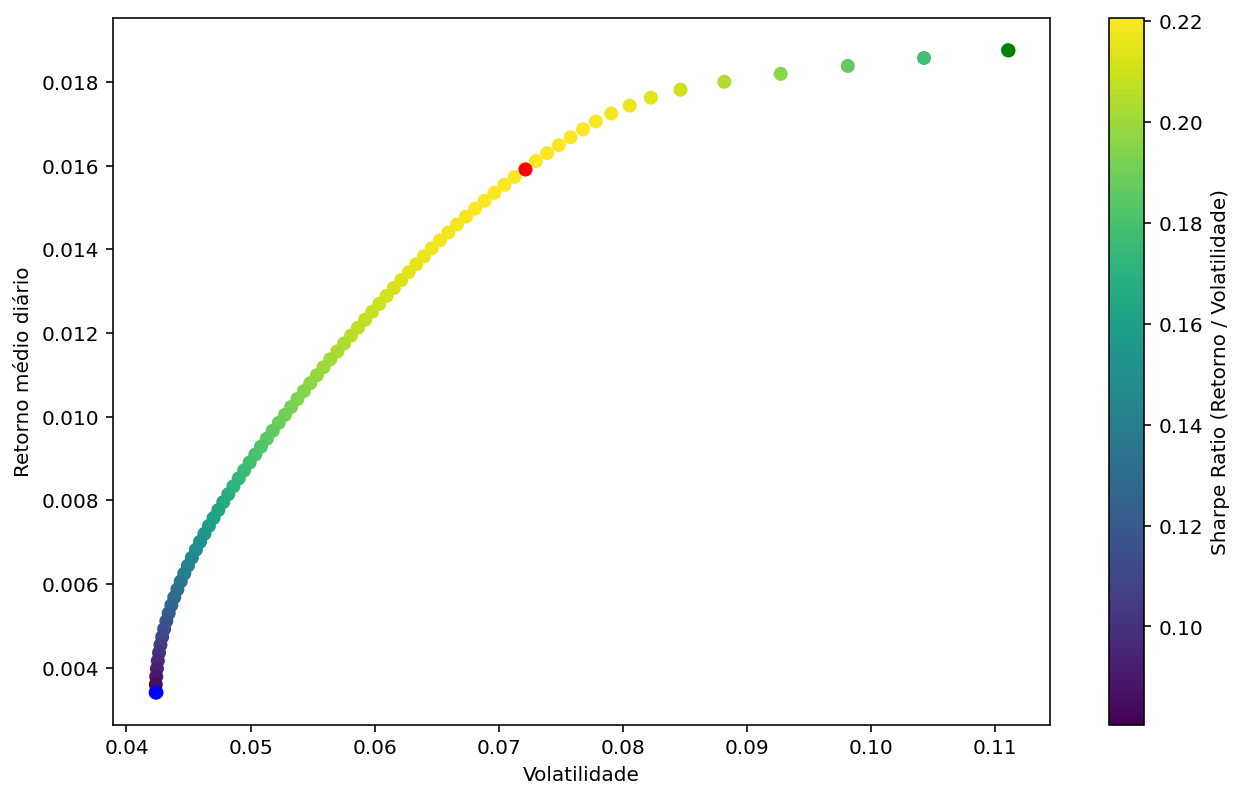

In [17]:
plt.figure(figsize=(10.5, 6.5))
plt.scatter(frontier_x, frontier_y, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio (Retorno / Volatilidade)')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno médio diário')

plt.scatter(frontier_x[sr_max_index], frontier_y[sr_max_index], c='red')# máximo sharpe ratio
plt.scatter(frontier_x[retorno_max_index], frontier_y[retorno_max_index], c='green')# máximo sharpe ratio
plt.scatter(frontier_x[volatilidade_min_index], frontier_y[volatilidade_min_index], c='blue')# máximo sharpe ratio
plt.show()

In [7]:
variacao_periodo = (precos.iloc[-1] - precos.iloc[0]) / precos.iloc[-1]
variacao_btc = (precos.iloc[-1]["BTC"] - precos.iloc[0]["BTC"]) / precos.iloc[-1]["BTC"] * 100

### Carteira com menor volatilidade

In [8]:
display( formatar_resultado(simbolos, pesos[volatilidade_min_index]) )

lucro = sum(variacao_periodo * pesos[volatilidade_min_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[volatilidade_min_index])

,peso
BTC,89.70
SOL,5.23
EGLD,4.47
ADA,0.60



Rentabilidade do BTC no período: 38.37%
Rentabilidade da carteira no período: 44.15%
Volatilidade da carteira no período: 0.042


### Carteira com maior retorno

In [9]:
display( formatar_resultado(simbolos, pesos[retorno_max_index]) )

lucro = sum(variacao_periodo * pesos[retorno_max_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[retorno_max_index])

,peso
LUNA,100.0



Rentabilidade do BTC no período: 38.37%
Rentabilidade da carteira no período: 98.99%
Volatilidade da carteira no período: 0.111


### Carteira com maior sharpe ratio (retorno / volatilidade)

In [10]:
display( formatar_resultado(simbolos, pesos[sr_max_index]) )

lucro = sum(variacao_periodo * pesos[sr_max_index]) * 100
print("\nRentabilidade do BTC no período: " + "%.2f" % variacao_btc + "%")
print("Rentabilidade da carteira no período: " + "%.2f" % lucro + "%")
print("Volatilidade da carteira no período: " + "%.3f" % frontier_x[sr_max_index])

,peso
SOL,49.35
LUNA,23.85
AVAX,12.29
EGLD,10.04
BNB,4.48



Rentabilidade do BTC no período: 38.37%
Rentabilidade da carteira no período: 97.49%
Volatilidade da carteira no período: 0.072


### Frequência dos ativos nas carteiras

In [11]:
carteiras = pd.DataFrame(columns=simbolos, data=pesos)
carteiras['sharpe_ratio'] = sharpe_ratio
carteiras['volatilidade'] = frontier_x
carteiras['retorno'] = frontier_y

In [12]:
soma_pesos = pd.DataFrame(columns=["pesos"], data=carteiras.sum())
soma_pesos = soma_pesos[0:-3]
soma_pesos = soma_pesos.sort_values(by='pesos', ascending=False)
soma_pesos = soma_pesos.applymap(lambda x: "%.2f" % x)
soma_pesos

,pesos
SOL,24.74
BTC,24.13
LUNA,12.94
EGLD,8.57
ADA,5.62
AVAX,2.80
BNB,2.20
ETH,1.01
LTC,0.00
LINK,0.00


### XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [13]:
# carteiras_formatadadas = carteiras.applymap(lambda x: "%.2f" % (x * 100) )
# carteiras.sort_values(by=['volatilidade', 'retorno'])